Adapted from MONAI
Copyright (c) MONAI Consortium
Licensed under the Apache License, Version 2.0 (the "License");
You may obtain a copy of the License at
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0

|# Using ControlNet to control image generation

This tutorial illustrates how to use MONAI Generative Models to train a ControlNet [1]. ControlNets are hypernetworks that allow for supplying extra conditioning to ready-trained diffusion models. In this example, we will walk through training a ControlNet that allows us to specify a whole-brain mask that the sampled image must respect.



In summary, the tutorial will cover the following:
1. Loading and preprocessing a dataset (we extract the brain MRI dataset 2D slices from 3D volumes from the BraTS dataset)
2. Training a 2D diffusion model
3. Freeze the diffusion model and train a ControlNet
3. Conditional sampling with the ControlNet

[1] - Zhang et al. [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)

## Setup environment

In [1]:
!python -c "import monai" || pip install  "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install  matplotlib
%matplotlib inline

## Setup imports

In [2]:
import os
import time
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.amp import GradScaler, autocast
from tqdm import tqdm
from monai.inferers import ControlNetDiffusionInferer, DiffusionInferer
from monai.networks.nets import DiffusionModelUNet, ControlNet
from monai.networks.schedulers import DDPMScheduler, DDPMScheduler, RFlowScheduler
# additional imports
from pathlib import Path

print_config()

MONAI version: 1.6.dev2528
Numpy version: 2.1.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7c86eeeae01528647a5703f2fd5df9bc10a8536f
MONAI __file__: C:\Users\<username>\anaconda3\envs\dmcaf\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.3
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.3.1
einops version: 0.8.1
transformers version: 4.53.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERS

### Set deterministic training for reproducibility

In [3]:
from models import SEED
set_determinism(SEED)

We create the training and validation datasets:

In [4]:
from data import get_datasets_and_loaders
train_ds, val_ds, train_loader, val_loader = get_datasets_and_loaders(batch_size=8, num_workers=0, verbose=True)

2025-07-23 15:26:38,668 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-07-23 15:26:38,669 - INFO - File exists: C:\Users\Marquis\Desktop\dmcaf\DMCAF\medical_image\Datasets\Task01_BrainTumour.tar, skipped downloading.
2025-07-23 15:26:38,670 - INFO - Non-empty folder exists in C:\Users\Marquis\Desktop\dmcaf\DMCAF\medical_image\Datasets\Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 388/388 [02:53<00:00,  2.24it/s]


Length of training data: 388
Train image shape torch.Size([1, 64, 64])
2025-07-23 15:29:41,299 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-07-23 15:29:41,300 - INFO - File exists: C:\Users\Marquis\Desktop\dmcaf\DMCAF\medical_image\Datasets\Task01_BrainTumour.tar, skipped downloading.
2025-07-23 15:29:41,301 - INFO - Non-empty folder exists in C:\Users\Marquis\Desktop\dmcaf\DMCAF\medical_image\Datasets\Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 96/96 [00:43<00:00,  2.22it/s]

Length of val data: 96
Validation image shape torch.Size([1, 64, 64])


### Visualise the images and masks
We load some images and masks to make sure things make sense:

Batch shape: torch.Size([8, 1, 64, 64])


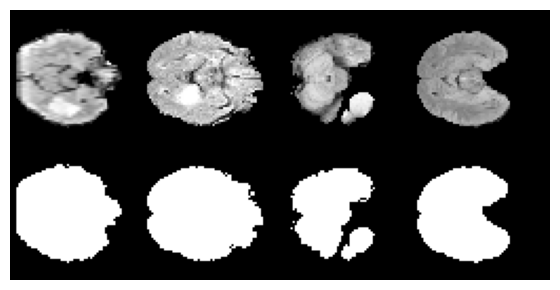

In [5]:
check_data = first(train_loader)
print(f"Batch shape: {check_data['image'].shape}")
image_visualisation = torch.cat(
    (
        torch.cat(
            [
                check_data["image"][0, 0],
                check_data["image"][1, 0],
                check_data["image"][2, 0],
                check_data["image"][3, 0],
            ],
            dim=1,
        ),
        torch.cat(
            [check_data["mask"][0, 0], check_data["mask"][1, 0], check_data["mask"][2, 0], check_data["mask"][3, 0]],
            dim=1,
        ),
    ),
    dim=0,
)
plt.figure(figsize=(6, 3))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

## Train the Diffusion model
In general, a ControlNet can be trained in combination with a pre-trained, frozen diffusion model. In this case we will quickly train the diffusion model first.

### Define network, scheduler, optimizer, and inferer

In [6]:
from models import get_model, get_scheduler, get_inferers

device = torch.device("cuda")

# Load model
model = get_model(device)
model_name = model.__class__.__name__
print(f"Model: {model_name}")

# Load scheduler and inferer
scheduler = get_scheduler()
inferer, _ = get_inferers(scheduler)

# Optimizer for the model
optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

Model: DiffusionModelUNet


### Run training


epoch:0/200: training loss 0.799991
validation loss: 0.0297
Best model saved at epoch 10 with val loss 0.0297
Checkpoint saved: checkpoint_epoch_10.pth
epoch:10/200: training loss 0.022175
validation loss: 0.0209
Best model saved at epoch 20 with val loss 0.0209
Checkpoint saved: checkpoint_epoch_20.pth
epoch:20/200: training loss 0.022233
validation loss: 0.0193
Best model saved at epoch 30 with val loss 0.0193
Checkpoint saved: checkpoint_epoch_30.pth


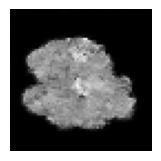

epoch:30/200: training loss 0.022679
validation loss: 0.0169
Best model saved at epoch 40 with val loss 0.0169
Checkpoint saved: checkpoint_epoch_40.pth
epoch:40/200: training loss 0.016717
validation loss: 0.0358
Checkpoint saved: checkpoint_epoch_50.pth
epoch:50/200: training loss 0.018825
validation loss: 0.0203
Checkpoint saved: checkpoint_epoch_60.pth


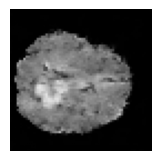

epoch:60/200: training loss 0.018502
validation loss: 0.0170
Checkpoint saved: checkpoint_epoch_70.pth
epoch:70/200: training loss 0.017603
validation loss: 0.0168
Best model saved at epoch 80 with val loss 0.0168
Checkpoint saved: checkpoint_epoch_80.pth
epoch:80/200: training loss 0.018401
validation loss: 0.0230
Checkpoint saved: checkpoint_epoch_90.pth


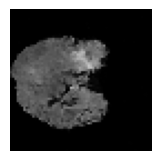

epoch:90/200: training loss 0.017710
validation loss: 0.0142
Best model saved at epoch 100 with val loss 0.0142
Checkpoint saved: checkpoint_epoch_100.pth
epoch:100/200: training loss 0.018693
validation loss: 0.0155
Checkpoint saved: checkpoint_epoch_110.pth
epoch:110/200: training loss 0.017173
validation loss: 0.0205
Checkpoint saved: checkpoint_epoch_120.pth


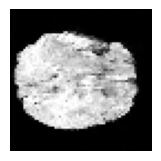

epoch:120/200: training loss 0.019250
validation loss: 0.0199
Checkpoint saved: checkpoint_epoch_130.pth
epoch:130/200: training loss 0.014900
validation loss: 0.0130
Best model saved at epoch 140 with val loss 0.0130
Checkpoint saved: checkpoint_epoch_140.pth
epoch:140/200: training loss 0.019648
validation loss: 0.0111
Best model saved at epoch 150 with val loss 0.0111
Checkpoint saved: checkpoint_epoch_150.pth


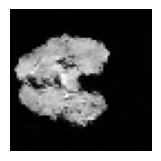

epoch:150/200: training loss 0.020430
validation loss: 0.0159
Checkpoint saved: checkpoint_epoch_160.pth
epoch:160/200: training loss 0.016302
validation loss: 0.0176
Checkpoint saved: checkpoint_epoch_170.pth
epoch:170/200: training loss 0.019065
validation loss: 0.0173
Checkpoint saved: checkpoint_epoch_180.pth


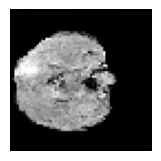

epoch:180/200: training loss 0.017439
validation loss: 0.0260
Checkpoint saved: checkpoint_epoch_190.pth
epoch:190/200: training loss 0.013182
validation loss: 0.0152
Checkpoint saved: checkpoint_epoch_200.pth
train completed, total time: 1056.3555870056152.


In [7]:
max_epochs = 200
val_interval = 10
val_interval_print = 30
epoch_loss_list = []
val_epoch_loss_list = []
print_every = 10

#highlight Model checkpointing
best_val_loss = float("inf")
checkpoint_dir = Path.cwd() / "Checkpoints" / model_name
checkpoint_dir.mkdir(parents=True, exist_ok=True)

scaler = GradScaler("cuda")
total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=False):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    if epoch % print_every == 0:
        msg = f"epoch:{epoch:d}/{max_epochs:d}: training loss {np.mean(epoch_loss / len(train_loader)):4f}"
        print(msg)

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for batch in val_loader:
            images = batch["image"].to(device)
            with torch.no_grad():
                with autocast("cuda", enabled=False):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
        avg_val_loss = val_epoch_loss / len(val_loader)
        val_epoch_loss_list.append(avg_val_loss)
        print(f"validation loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_path = checkpoint_dir / "best_model.pth"
            torch.save(model.state_dict(), best_path)
            print(f"Best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

        # Save periodic checkpoint
        checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path.name}")


        if (epoch + 1) % val_interval_print == 0:
            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast("cuda", enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler, verbose=False)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## Train the ControlNet

### Set up models

In [10]:
from models import get_controlnet, get_inferers

# Create controlnet and freeze diffusion model weights
controlnet = get_controlnet(device, model, scheduler)

# Get ControlNet inferer
_, controlnet_inferer = get_inferers(scheduler)

# Set model name
controlnet_model_name = controlnet.__class__.__name__ + "_" + model.__class__.__name__
print(f"ControlNet: {controlnet_model_name}")

# Optimizer for ControlNet only
optimizer = torch.optim.Adam(params=controlnet.parameters(), lr=2.5e-5)


ControlNet: ControlNet_DiffusionModelUNet


### Run ControlNet training

epoch:0/150: training loss 0.016188
epoch:10/150: training loss 0.014509
epoch:20/150: training loss 0.016759
validation loss: 0.0143
Best ControlNet saved at epoch 25 with val loss 0.0143
Checkpoint saved: checkpoint_epoch_25.pth


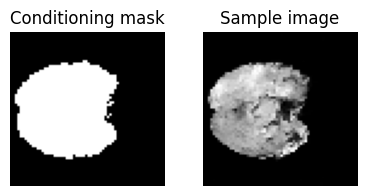

epoch:30/150: training loss 0.014574
epoch:40/150: training loss 0.017744
validation loss: 0.0092
Best ControlNet saved at epoch 50 with val loss 0.0092
Checkpoint saved: checkpoint_epoch_50.pth


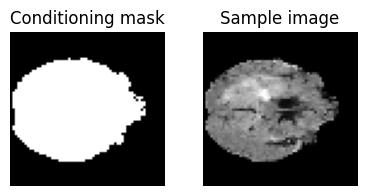

epoch:50/150: training loss 0.013033
epoch:60/150: training loss 0.012761
epoch:70/150: training loss 0.012145
validation loss: 0.0165
Checkpoint saved: checkpoint_epoch_75.pth


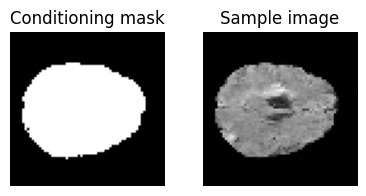

epoch:80/150: training loss 0.013661
epoch:90/150: training loss 0.017802
validation loss: 0.0112
Checkpoint saved: checkpoint_epoch_100.pth


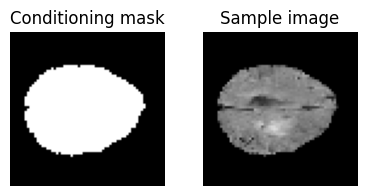

epoch:100/150: training loss 0.017299
epoch:110/150: training loss 0.013248
epoch:120/150: training loss 0.015510
validation loss: 0.0146
Checkpoint saved: checkpoint_epoch_125.pth


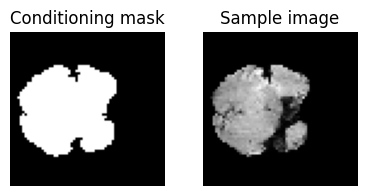

epoch:130/150: training loss 0.019141
epoch:140/150: training loss 0.013108
validation loss: 0.0145
Checkpoint saved: checkpoint_epoch_150.pth


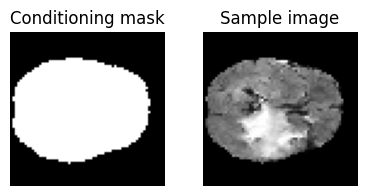

train completed, total time: 780.0026879310608.


In [9]:
max_epochs = 150
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []

#highlight ControlNet checkpointing
best_val_loss = float("inf")
controlnet_ckpt_dir = Path.cwd() / "Checkpoints" / controlnet_model_name
controlnet_ckpt_dir.mkdir(parents=True, exist_ok=True)


scaler = GradScaler("cuda")
total_start = time.time()
for epoch in range(max_epochs):
    controlnet.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            noise_pred = controlnet_inferer(
                inputs=images,
                diffusion_model=model,
                controlnet=controlnet,
                noise=noise,
                timesteps=timesteps,
                cn_cond=masks,
            )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    if epoch % print_every == 0:
        msg = f"epoch:{epoch:d}/{max_epochs:d}: training loss {np.mean(epoch_loss / len(train_loader)):4f}"
        print(msg)

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if (epoch + 1) % val_interval == 0:
        controlnet.eval()
        val_epoch_loss = 0
        for batch in val_loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)

            with torch.no_grad():
                with autocast("cuda", enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, controlnet_inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    noise_pred = controlnet_inferer(
                        inputs=images,
                        diffusion_model=model,
                        controlnet=controlnet,
                        noise=noise,
                        timesteps=timesteps,
                        cn_cond=masks,
                    )
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())
            val_epoch_loss += val_loss.item()

        avg_val_loss = val_epoch_loss / len(val_loader)
        val_epoch_loss_list.append(avg_val_loss)
        print(f"validation loss: {avg_val_loss:.4f}")

        # Save best ControlNet model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_path = controlnet_ckpt_dir / "best_model.pth"
            torch.save(controlnet.state_dict(), best_path)
            print(f"Best ControlNet saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

        # Save periodic ControlNet checkpoint
        checkpoint_path = controlnet_ckpt_dir / f"checkpoint_epoch_{epoch+1}.pth"
        torch.save(controlnet.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path.name}")


        # Sampling image during training with controlnet conditioning

        with torch.no_grad():
            with autocast("cuda", enabled=True):
                noise = torch.randn((1, 1, 64, 64)).to(device)
                sample = controlnet_inferer.sample(
                    input_noise=noise,
                    diffusion_model=model,
                    controlnet=controlnet,
                    cn_cond=masks[0, None, ...],
                    scheduler=scheduler,
                    verbose=False,
                )
        plt.subplots(1, 2, figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(masks[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Conditioning mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sample[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Sample image")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## Sample with ControlNet conditioning
First we'll provide a few different masks from the validation data as conditioning. The samples should respect the shape of the conditioning mask, but don't need to have the same content as the corresponding validation image.

Model loaded from C:\Users\Marquis\Desktop\dmcaf\DMCAF\medical_image\Checkpoints\DiffusionModelUNet\best_model.pth


sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.59it/s]


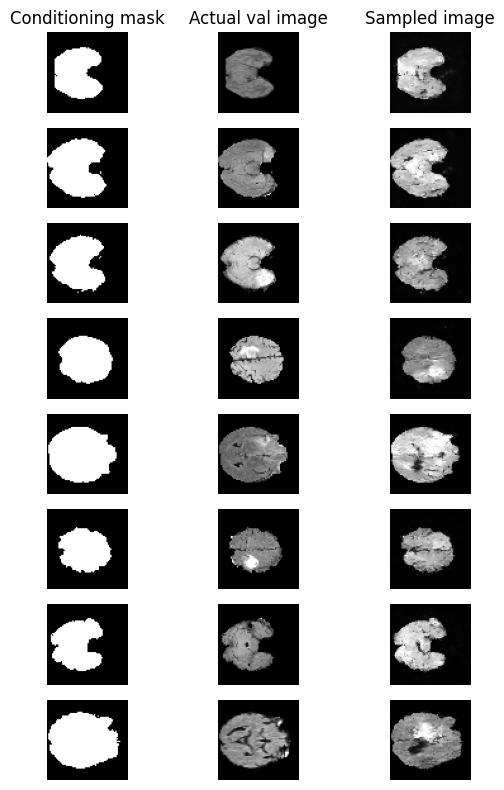

In [11]:
#highlight Model and ControlNet checkpoint loading

model_ckpt_path = Path.cwd() / "Checkpoints" / model_name / "best_model.pth"
controlnet_ckpt_path = Path.cwd() / "Checkpoints" / controlnet_model_name / "best_model.pth"

model.load_state_dict(torch.load(model_ckpt_path, map_location=device))
controlnet.load_state_dict(torch.load(controlnet_ckpt_path, map_location=device))
print(f"Model loaded from {model_ckpt_path}")

model.eval()
controlnet.eval()


progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
progress_bar_sampling.set_description("sampling...")
num_samples = 8
sample = torch.randn((num_samples, 1, 64, 64)).to(device)

val_batch = first(val_loader)
val_images = val_batch["image"].to(device)
val_masks = val_batch["mask"].to(device)
for t in progress_bar_sampling:
    with torch.no_grad():
        with autocast("cuda", enabled=True):
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample,
                timesteps=torch.Tensor((t,)).to(device).long(),
                controlnet_cond=val_masks[:num_samples, ...]
            )
            noise_pred = model(
                sample,
                timesteps=torch.Tensor((t,)).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

plt.subplots(num_samples, 3, figsize=(6, 8))
for k in range(num_samples):
    plt.subplot(num_samples, 3, k * 3 + 1)
    plt.imshow(val_masks[k, 0, ...].numpy().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Conditioning mask")
    plt.subplot(num_samples, 3, k * 3 + 2)
    plt.imshow(val_images[k, 0, ...].numpy().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Actual val image")
    plt.subplot(num_samples, 3, k * 3 + 3)
    plt.imshow(sample[k, 0, ...].numpy().cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Sampled image")
plt.tight_layout()
plt.show()

What happens if we invent some masks? Let's try a circle, and a square

sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 54.31it/s]


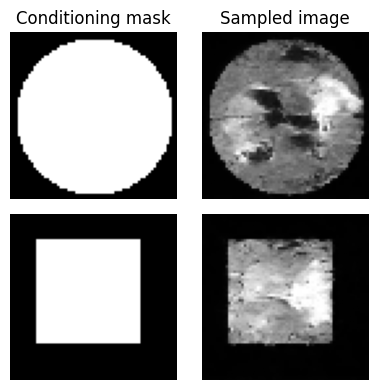

In [16]:
xx, yy = np.mgrid[:64, :64]
circle = ((xx - 32) ** 2 + (yy - 32) ** 2) < 30**2

square = np.zeros((64, 64))
square[10:50, 10:50] = 1

mask = np.concatenate((circle[None, None, ...], square[None, None, ...]), axis=0)
mask = torch.from_numpy(mask.astype(np.float32)).to(device)


progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
progress_bar_sampling.set_description("sampling...")
num_samples = 2
sample = torch.randn((num_samples, 1, 64, 64)).to(device)

for t in progress_bar_sampling:
    with torch.no_grad():
        with autocast("cuda", enabled=True):
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample, timesteps=torch.Tensor((t,)).to(device).long(), controlnet_cond=mask
            )
            noise_pred = model(
                sample,
                timesteps=torch.Tensor((t,)).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

plt.subplots(num_samples, 2, figsize=(4, 4))
for k in range(num_samples):
    plt.subplot(num_samples, 2, k * 2 + 1)
    plt.imshow(mask[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Conditioning mask")
    plt.subplot(num_samples, 2, k * 2 + 2)
    plt.imshow(sample[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Sampled image")
plt.tight_layout()
plt.show()